# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [8]:
import sys
from pathlib import Path
import re
def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/zohra/mlfs-book
HopsworksSettings initialized!


In [9]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os
import importlib
importlib.reload(util)

<module 'mlfs.airquality.util' from '/home/zohra/mlfs-book/mlfs/airquality/util.py'>

In [10]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 16, 16, 42, 3, 730648)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [11]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)

2025-11-16 16:42:03,753 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 16:42:03,757 INFO: Initializing external client
2025-11-16 16:42:03,759 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-16 16:42:04,643 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-16 16:42:05,463 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279126


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [12]:
mr = project.get_model_registry()
air_quality_fg = fs.get_feature_group(
    name='air_quality_per_city',
    version=2,
)
target_city = "catalunya"

city_info = next(
    loc for loc in location 
    if loc["city"].lower() == target_city.lower()
)
country = city_info["country"]
city =target_city
weather_fg = fs.get_feature_group(
    name='weather_spain',
    version=1,
)
selected_features = (
    air_quality_fg
    .select(['pm25', 'date', 'rolling_mean', 'city', 'street'])
    .join(
        weather_fg.select_features(),
        on=['city']
    )
)

selected_features_df = selected_features.read().sort_values("date")


streets = selected_features_df["street"].dropna().unique()
models_by_street = {}

for s in streets:
    safe_street = re.sub(r"[^A-Za-z0-9]+", "_", s)
    model_name = "air_quality_xgboost_" + safe_street

    try:
        # 1) Get all versions of this model name
        all_versions = mr.get_models(name=model_name)

        if not all_versions:
            print(f" No model versions found for street '{s}' with name '{model_name}'")
            continue

        # 2) Take the latest by version number
        latest_model = max(all_versions, key=lambda m: m.version)

        models_by_street[s] = latest_model
        print(f" Found model '{model_name}' v{latest_model.version} for street '{s}'")

    except Exception as e:
        print(f" Error fetching model for street '{s}' with name '{model_name}': {e}")


2025-11-16 16:42:08,437 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_spain` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.39s) 
 Found model 'air_quality_xgboost_barcelona_gracia_st_gervasi' v11 for street 'barcelona-gracia-st.gervasi'
 Found model 'air_quality_xgboost_barcelona_parc_vall_dhebron' v11 for street 'barcelona-parc-vall-dhebron'
 Found model 'air_quality_xgboost_barcelona' v11 for street 'barcelona'
 Found model 'air_quality_xgboost_barcelona_eixample' v10 for street 'barcelona-eixample'
 Found model 'air_quality_xgboost_barcelona_palau_reial' v8 for street 'barcelona-palau-reial'
 Found model 'air_quality_xgboost_barcelona_poblenou' v8 for street 'barcelona-poblenou'


In [13]:
import os
from xgboost import XGBRegressor

xgb_models = {} 

for street, model_meta in models_by_street.items():
    print(street, "->", model_meta)
    # 1) Download the directory for this street’s model
    model_dir = model_meta.download()
    
    # 2) Find the model JSON file automatically
    model_json = None
    for f in os.listdir(model_dir):
        if f.endswith(".json"):
            model_json = os.path.join(model_dir, f)
            break

    if model_json is None:
        print(f" No JSON model file found for {street}")
        continue

    # 3) Load into XGBoost
    model = XGBRegressor()
    model.load_model(model_json)

    xgb_models[street] = model
    print(f" Loaded XGBoost model for {street}")


barcelona-gracia-st.gervasi -> Model(name: 'air_quality_xgboost_barcelona_gracia_st_gervasi', version: 11)


Downloading: 0.000%|          | 0/443483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/452516 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/110543 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/94878 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/99023 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/97955 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/94738 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/93347 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/98365 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/111816 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/20304 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/29145 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28163 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28350 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28497 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28078 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28515 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/18686 elapsed<00:00 remaining<?

 Loaded XGBoost model for barcelona-gracia-st.gervasi
barcelona-parc-vall-dhebron -> Model(name: 'air_quality_xgboost_barcelona_parc_vall_dhebron', version: 11)


Downloading: 0.000%|          | 0/443483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/452516 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/110543 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/94878 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/98984 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/97955 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/94738 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/93347 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/98365 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/111816 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/20304 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/29145 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28163 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28350 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28497 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28078 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28515 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/18686 elapsed<00:00 remaining<?

 Loaded XGBoost model for barcelona-parc-vall-dhebron
barcelona -> Model(name: 'air_quality_xgboost_barcelona', version: 11)


Downloading: 0.000%|          | 0/443483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/452516 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/110543 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/94878 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/98984 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/97955 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/94738 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/93347 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/98406 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/111816 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/20304 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/29145 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28163 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28350 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28497 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28078 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28515 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/18686 elapsed<00:00 remaining<?

 Loaded XGBoost model for barcelona 18 files)... DONE
barcelona-eixample -> Model(name: 'air_quality_xgboost_barcelona_eixample', version: 10)


Downloading: 0.000%|          | 0/443483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/452516 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/110543 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/94878 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/98984 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/97955 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/94738 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/93513 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/98406 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/111816 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/20304 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/29145 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28163 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28350 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28497 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28078 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28515 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/18686 elapsed<00:00 remaining<?

 Loaded XGBoost model for barcelona-eixample)... DONE
barcelona-palau-reial -> Model(name: 'air_quality_xgboost_barcelona_palau_reial', version: 8)


Downloading: 0.000%|          | 0/443483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/452516 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/110543 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/94878 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/98984 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/97781 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/94738 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/93513 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/98406 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/111816 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/20304 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/29145 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28163 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28350 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28497 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28078 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28515 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/18686 elapsed<00:00 remaining<?

 Loaded XGBoost model for barcelona-palau-reial. DONE
barcelona-poblenou -> Model(name: 'air_quality_xgboost_barcelona_poblenou', version: 8)


Downloading: 0.000%|          | 0/443483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/452516 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/110543 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/94870 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/98984 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/97781 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/94738 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/93513 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/98406 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/111816 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/20304 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/29145 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28163 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28350 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28497 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28078 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28515 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/18686 elapsed<00:00 remaining<?

 Loaded XGBoost model for barcelona-poblenou)... DONE


In [14]:
air_quality_df = air_quality_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.59s) 


In [15]:
batch_data = weather_fg.filter(weather_fg.date >= today).read()
m=batch_data.sort_values("date", ascending=True).copy()
m

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.67s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
4,2025-11-17 00:00:00+00:00,12.70,0.0,4.896529,197.102814,catalunya
1,2025-11-18 00:00:00+00:00,6.70,0.0,8.217153,241.189301,catalunya
5,2025-11-19 00:00:00+00:00,5.15,0.0,6.725354,254.475830,catalunya
0,2025-11-20 00:00:00+00:00,7.15,0.0,15.978484,247.479385,catalunya
2,2025-11-21 00:00:00+00:00,2.90,0.0,21.129883,314.309814,catalunya
3,2025-11-22 00:00:00+00:00,7.05,0.0,7.172949,252.474335,catalunya


In [16]:
def recursive_predict_with_rolling_3(model, air_quality_df, batch_data):
   

    # Make sure historical data is ordered from most recent to oldest
    hist = air_quality_df.sort_values("date", ascending=False).copy()

    # last 3 *real* pm25 values (most recent first)
    history = list(hist["pm25"].iloc[:3])

    batch_sorted = batch_data.sort_values("date", ascending=True).copy()

    rolling_means = []

    feature_cols = [
        "rolling_mean",
        "temperature_2m_mean",
        "precipitation_sum",
        "wind_speed_10m_max",
        "wind_direction_10m_dominant",
    ]

    for _, row in batch_sorted.iterrows():
    
        window = history[:3]
        rolling_mean = sum(window) / len(window)
        rolling_means.append(rolling_mean)

        # --- build features for this horizon ---
        row_features = row.copy()
        row_features["rolling_mean"] = rolling_mean
        
        X = row_features[feature_cols].to_frame().T
        X = X.astype(float)

        y_hat = model.predict(X)[0]

        history = [y_hat] + history[:2]

    batch_sorted["rolling_mean"] = rolling_means

    # put back in original order if needed
    return batch_sorted


In [17]:
batch_data_by_street = {}
for s in xgb_models.keys():
    batch_data_by_street[s] = recursive_predict_with_rolling_3(
    model=xgb_models[s],
    air_quality_df = air_quality_df[air_quality_df["street"] == s],
    batch_data=batch_data,
)

In [18]:
debug=pd.to_datetime(batch_data_by_street['barcelona']['date']).dt.date
debug

4    2025-11-17
1    2025-11-18
5    2025-11-19
0    2025-11-20
2    2025-11-21
3    2025-11-22
Name: date, dtype: object

In [19]:
for s in batch_data_by_street.keys():
    batch_data_by_street[s]['predicted_pm25'] = xgb_models[s].predict(
    batch_data_by_street[s][['rolling_mean','temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])


In [20]:
for s in batch_data_by_street.keys():
    batch_data_by_street[s]['street'] = s
    batch_data_by_street[s]['city'] = city
    batch_data_by_street[s]['country'] = country
    # Fill in the number of days before the date on which you made the forecast (base_date)
    batch_data_by_street[s]['days_before_forecast_day'] = range(1, len(batch_data)+1)
    batch_data_by_street[s] = batch_data_by_street[s].sort_values(by=['date'])

2025-11-16 16:43:41,651 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



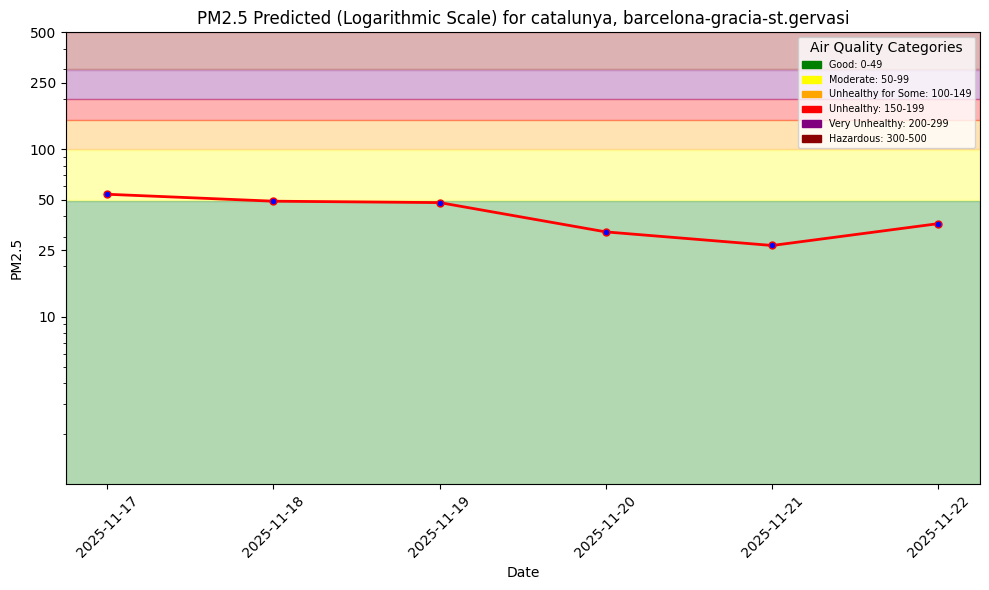

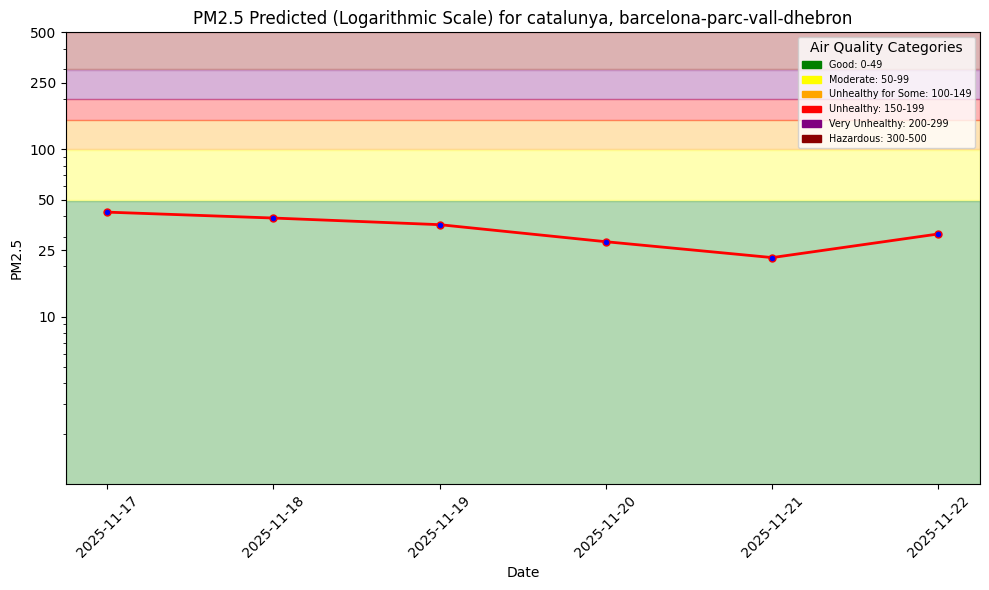

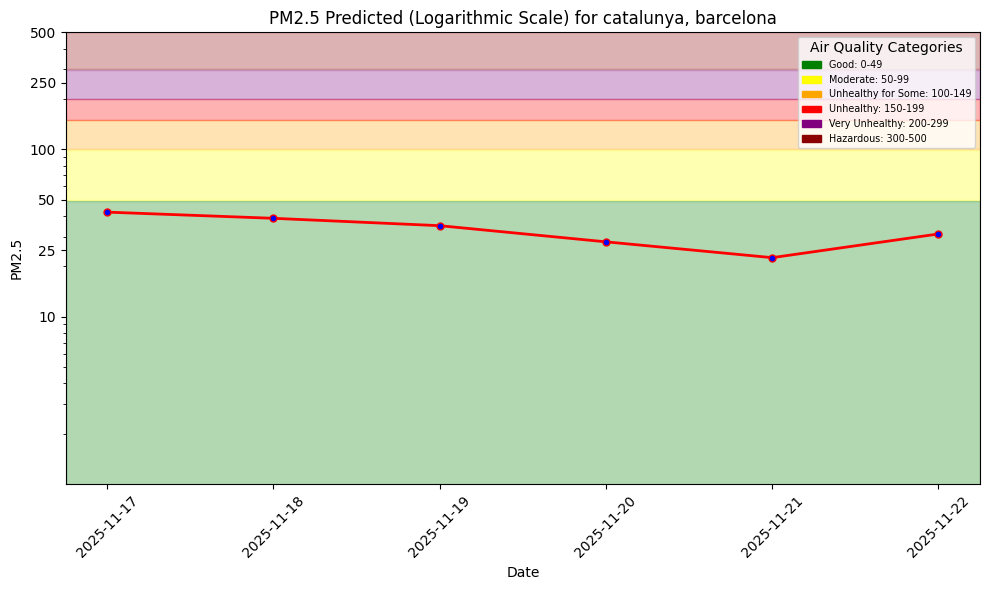

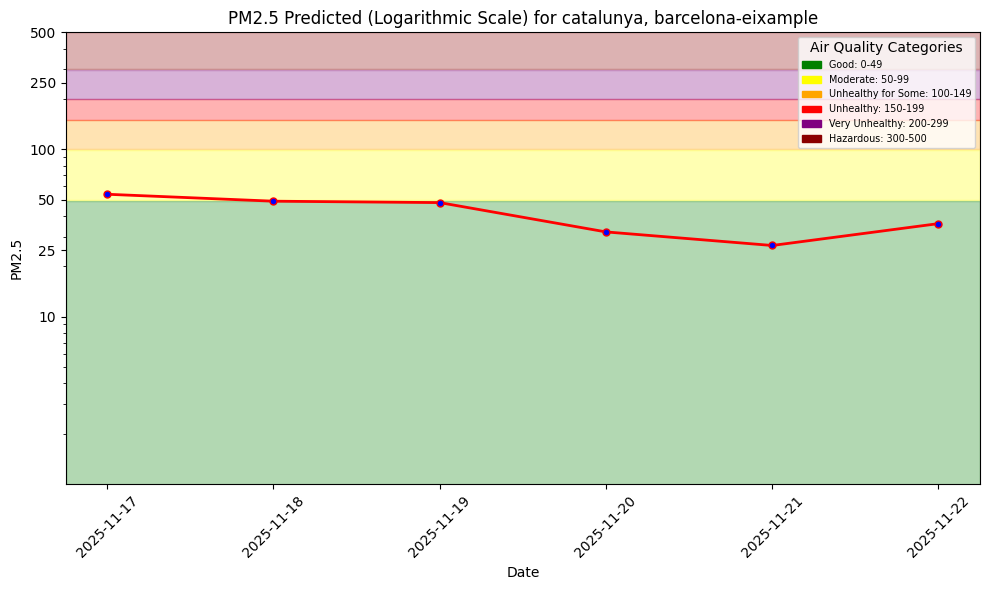

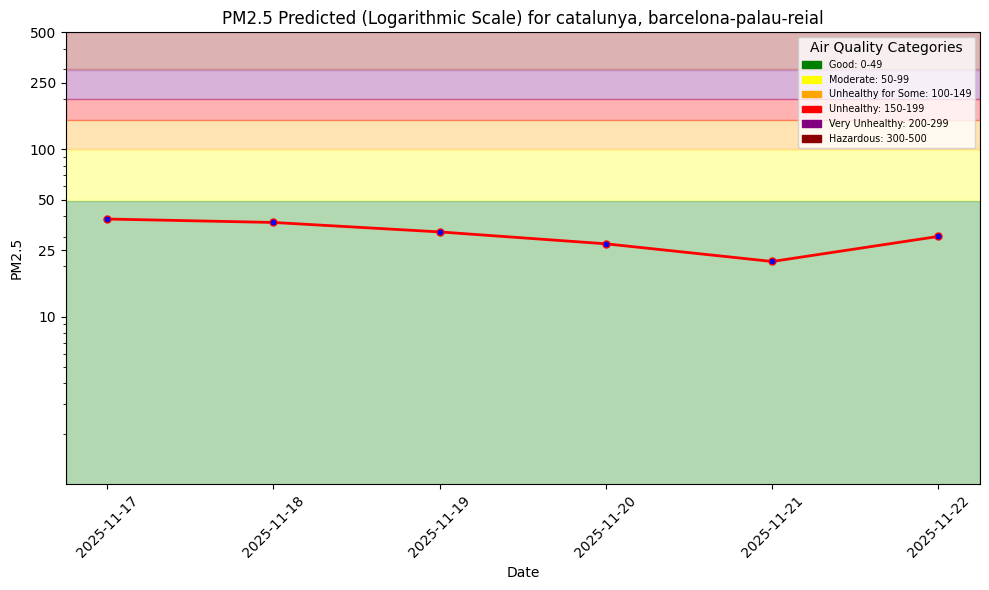

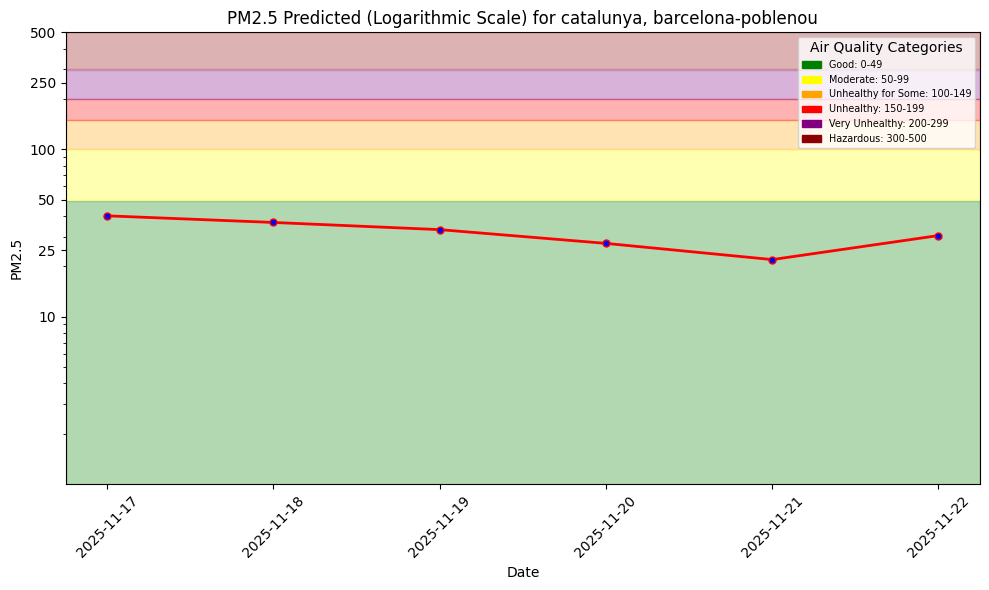

In [21]:
for street, data in batch_data_by_street.items():
    path_name = re.sub(r"[^A-Za-z0-9]+","_", street)
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{path_name}.png"
    plt = util.plot_air_quality_forecast(city, street, data, pred_file_path)
    plt.show()

In [22]:
batch_data_by_street['barcelona'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 4 to 3
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   rolling_mean                 6 non-null      float64                
 7   predicted_pm25               6 non-null      float32                
 8   street                       6 non-null      object                 
 9   country                      6 non-null      object                 
 10  days_before

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

In [40]:
batch_data_by_street[street]

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,rolling_mean,predicted_pm25,street,country,days_before_forecast_day
4,2025-11-17 00:00:00+00:00,12.70,0.0,4.896529,197.102814,catalunya,40.000000,42.144714,barcelona,spain,1
1,2025-11-18 00:00:00+00:00,6.70,0.0,8.217153,241.189301,catalunya,38.048238,38.713959,barcelona,spain,2
5,2025-11-19 00:00:00+00:00,5.15,0.0,6.725354,254.475830,catalunya,32.619558,34.980129,barcelona,spain,3
0,2025-11-20 00:00:00+00:00,7.15,0.0,15.978484,247.479385,catalunya,38.612934,28.008163,barcelona,spain,4
2,2025-11-21 00:00:00+00:00,2.90,0.0,21.129883,314.309814,catalunya,33.900750,22.531326,barcelona,spain,5
3,2025-11-22 00:00:00+00:00,7.05,0.0,7.172949,252.474335,catalunya,28.506540,31.216295,barcelona,spain,6


In [51]:
monitors_fg_by_street[street].read().sort_values("date", ascending=True).tail(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.20s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,rolling_mean,predicted_pm25,street,country,days_before_forecast_day
3,2025-11-17 00:00:00+00:00,12.70,0.0,4.896529,197.102814,catalunya,37.000000,40.055759,barcelona-poblenou,spain,1
2,2025-11-18 00:00:00+00:00,6.70,0.0,8.217153,241.189301,catalunya,35.018586,36.564167,barcelona-poblenou,spain,2
1,2025-11-19 00:00:00+00:00,5.15,0.0,6.725354,254.475830,catalunya,31.206642,33.128418,barcelona-poblenou,spain,3
4,2025-11-20 00:00:00+00:00,7.15,0.0,15.978484,247.479385,catalunya,36.582781,27.417324,barcelona-poblenou,spain,4
5,2025-11-21 00:00:00+00:00,2.90,0.0,21.129883,314.309814,catalunya,32.369970,21.938244,barcelona-poblenou,spain,5
0,2025-11-22 00:00:00+00:00,7.05,0.0,7.172949,252.474335,catalunya,27.494662,30.530727,barcelona-poblenou,spain,6


In [50]:
# Get or create feature group
monitors_fg_by_street = {}
monitors_df_by_street = {}
for street in streets:
    feature_name = 'aq_predictions_'+ re.sub(r"[^A-Za-z0-9]+","_", street)
    monitor_fg = fs.get_or_create_feature_group(
        name=feature_name,
        description='Air Quality prediction monitoring',
        version=2,
        primary_key=['city','street','date','days_before_forecast_day'],
        event_time="date"
    )
    monitor_fg.insert(batch_data_by_street[street], wait=True)
    monitors_df_by_street[street] = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
    monitors_fg_by_street[street] = monitor_fg

Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time


Launching job: aq_predictions_barcelona_gracia_st_gervasi_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_gracia_st_gervasi_2_offline_fg_materialization/executions
2025-11-16 17:24:13,403 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 17:24:16,654 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


%6|1763310267.457|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 50058ms in state UP)
%6|1763310270.836|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50129ms in state UP)
%6|1763310272.065|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 54040ms in state UP)
%6|1763310272.330|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 54417ms in state UP)
%6|1763310318.454|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50176ms in state UP)
%6|1763310321.013|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 103101ms in state UP)
%6|1763310321.832|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: Gr

2025-11-16 17:25:58,808 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 17:25:59,007 INFO: Waiting for log aggregation to finish.


%6|1763310369.653|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 50177ms in state UP)
%6|1763310372.496|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50001ms in state UP, 1 identical error(s) suppressed)
%6|1763310372.722|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50231ms in state UP, 1 identical error(s) suppressed)


2025-11-16 17:26:17,826 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.18s) 
Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279126/fs/1265733/fg/1718736


Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time


Launching job: aq_predictions_barcelona_parc_vall_dhebron_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_parc_vall_dhebron_2_offline_fg_materialization/executions
2025-11-16 17:26:40,275 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 17:26:46,627 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


%6|1763310420.649|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 50175ms in state UP, 1 identical error(s) suppressed)
%6|1763310422.902|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 100092ms in state UP, 1 identical error(s) suppressed)
%6|1763310423.414|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50177ms in state UP, 1 identical error(s) suppressed)
%6|1763310471.646|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 50177ms in state UP, 1 identical error(s) suppressed)
%6|1763310474.205|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 49972ms in state UP, 1 identical error(s) suppressed)


2025-11-16 17:28:25,951 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 17:28:26,156 INFO: Waiting for log aggregation to finish.


%6|1763310525.201|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50176ms in state UP, 1 identical error(s) suppressed)


2025-11-16 17:28:48,564 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.02s) 
Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279126/fs/1265733/fg/1724773


Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time


Launching job: aq_predictions_barcelona_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_2_offline_fg_materialization/executions
2025-11-16 17:29:09,881 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 17:29:16,240 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


%6|1763310566.878|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 94414ms in state UP, 1 identical error(s) suppressed)
%6|1763310575.378|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 151145ms in state UP, 1 identical error(s) suppressed)
%6|1763310576.196|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50176ms in state UP, 1 identical error(s) suppressed)
%6|1763310618.692|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50177ms in state UP, 1 identical error(s) suppressed)
%6|1763310626.884|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 49971ms in state UP, 1 identical error(s) suppressed)
%6|1763310627.135|FAIL|rdkafka#consumer-14| [thrd:GroupCoordin

2025-11-16 17:31:07,848 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 17:31:08,051 INFO: Waiting for log aggregation to finish.


%6|1763310669.688|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 50177ms in state UP, 1 identical error(s) suppressed)
%6|1763310677.652|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50002ms in state UP, 1 identical error(s) suppressed)
%6|1763310677.878|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 50230ms in state UP, 1 identical error(s) suppressed)


2025-11-16 17:31:26,876 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.33s) 
Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279126/fs/1265733/fg/1724774


Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time


Launching job: aq_predictions_barcelona_eixample_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_eixample_2_offline_fg_materialization/executions
2025-11-16 17:31:49,116 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 17:31:52,289 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


%6|1763310720.684|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 50177ms in state UP, 1 identical error(s) suppressed)
%6|1763310727.851|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 99943ms in state UP, 1 identical error(s) suppressed)
%6|1763310728.363|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50204ms in state UP, 1 identical error(s) suppressed)
%6|1763310771.782|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 50176ms in state UP, 1 identical error(s) suppressed)
%6|1763310778.950|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50036ms in state UP, 1 identical error(s) suppressed)
%6|1763310778.950|FAIL|rdkafka#consumer-14| [thrd:GroupCoordina

2025-11-16 17:33:43,742 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 17:33:43,907 INFO: Waiting for log aggregation to finish.


%6|1763310829.638|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50193ms in state UP, 1 identical error(s) suppressed)
%6|1763310830.093|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 50120ms in state UP, 1 identical error(s) suppressed)


2025-11-16 17:34:06,023 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.09s) 
Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279126/fs/1265733/fg/1718738


Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:02 | Remaining Time


Launching job: aq_predictions_barcelona_palau_reial_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_palau_reial_2_offline_fg_materialization/executions


%6|1763310866.912|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 94414ms in state UP, 1 identical error(s) suppressed)


2025-11-16 17:34:28,154 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 17:34:31,330 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


%6|1763310879.815|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 100251ms in state UP, 1 identical error(s) suppressed)
%6|1763310880.430|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50138ms in state UP, 1 identical error(s) suppressed)
%6|1763310918.727|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 50177ms in state UP, 1 identical error(s) suppressed)
%6|1763310931.015|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 49972ms in state UP, 1 identical error(s) suppressed)
%6|1763310969.518|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 50135ms in state UP, 1 identical error(s) suppressed)


2025-11-16 17:36:16,484 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 17:36:16,690 INFO: Waiting for log aggregation to finish.


%6|1763310981.192|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 100148ms in state UP, 1 identical error(s) suppressed)
%6|1763310981.704|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50140ms in state UP, 1 identical error(s) suppressed)


2025-11-16 17:36:35,663 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.18s) 
Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279126/fs/1265733/fg/1718739


Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:02 | Remaining Time


Launching job: aq_predictions_barcelona_poblenou_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_poblenou_2_offline_fg_materialization/executions
2025-11-16 17:36:58,195 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED


%6|1763311020.617|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 50178ms in state UP, 1 identical error(s) suppressed)


2025-11-16 17:37:01,377 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


%6|1763311032.494|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50059ms in state UP, 1 identical error(s) suppressed)
%6|1763311032.698|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50267ms in state UP, 1 identical error(s) suppressed)
%6|1763311071.583|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50123ms in state UP, 1 identical error(s) suppressed)
%6|1763311082.671|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 99637ms in state UP, 1 identical error(s) suppressed)
%6|1763311083.490|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50175ms in state UP, 1 identical error(s) suppressed)
%6|1763311134.178|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: Gr

2025-11-16 17:38:56,152 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-16 17:38:59,364 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 17:38:59,570 INFO: Waiting for log aggregation to finish.
2025-11-16 17:39:21,812 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.08s) 


In [25]:
monitors_fg_by_street['barcelona'].read().info()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.82s) 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         96 non-null     datetime64[us, Etc/UTC]
 1   temperature_2m_mean          96 non-null     float32                
 2   precipitation_sum            96 non-null     float32                
 3   wind_speed_10m_max           96 non-null     float32                
 4   wind_direction_10m_dominant  96 non-null     float32                
 5   city                         96 non-null     object                 
 6   rolling_mean                 96 non-null     float64                
 7   predicted_pm25               96 non-null     float32                
 8   street                       96 non-null     object               

In [52]:
air_quality_fg = fs.get_feature_group(name='air_quality_per_city', version=2)
air_quality_df = air_quality_fg.read()
air_quality_df

%6|1763311818.011|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50176ms in state UP, 1 identical error(s) suppressed)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.25s) 


,date,pm25,street,url,country,city,rolling_mean
0,2025-09-13 00:00:00+00:00,40.0,barcelona-gracia-st.gervasi,https://api.waqi.info/feed/@11758,spain,catalunya,35.333332
1,2025-06-05 00:00:00+00:00,43.0,barcelona-poblenou,https://api.waqi.info/feed/@10534/,spain,catalunya,33.000000
2,2023-08-02 00:00:00+00:00,49.0,barcelona-gracia-st.gervasi,https://api.waqi.info/feed/@11758,spain,catalunya,31.333334
3,2023-04-01 00:00:00+00:00,50.0,barcelona-gracia-st.gervasi,https://api.waqi.info/feed/@11758,spain,catalunya,25.000000
4,2025-06-09 00:00:00+00:00,55.0,barcelona-gracia-st.gervasi,https://api.waqi.info/feed/@11758,spain,catalunya,60.333332
...,...,...,...,...,...,...,...
7119,2025-11-16 00:00:00+00:00,65.0,barcelona-eixample,https://api.waqi.info/feed/@6669/,spain,catalunya,33.000000
7120,2025-11-16 00:00:00+00:00,17.0,barcelona-palau-reial,https://api.waqi.info/feed/@10532,spain,catalunya,33.000000
7121,2025-11-16 00:00:00+00:00,65.0,barcelona-gracia-st.gervasi,https://api.waqi.info/feed/@11758,spain,catalunya,33.000000
7122,2025-11-16 00:00:00+00:00,17.0,barcelona-parc-vall-dhebron,https://api.waqi.info/feed/@10533/,spain,catalunya,33.000000


In [53]:
hindcasts={}
for street, monitor in monitors_df_by_street.items():
    outcome_df = air_quality_df[air_quality_df["street"] == street][['date', 'pm25']]
    preds_df =  monitor[['date', 'predicted_pm25']]
    
    hindcast_df = pd.merge(preds_df, outcome_df, on="date")
    hindcast_df = hindcast_df.sort_values(by=['date'])
    
    # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
    if len(hindcast_df) == 0:
        hindcast_df = util.backfill_predictions_for_monitoring_per_street(weather_fg, air_quality_fg, monitors_fg_by_street[street], xgb_models[street],street)
    hindcasts[street]=hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.72s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.75s) 


Uploading Dataframe: 100.00% |█| Rows 10/10 | Elapsed Time: 00:01 | Remaining Ti


Launching job: aq_predictions_barcelona_gracia_st_gervasi_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_gracia_st_gervasi_2_offline_fg_materialization/executions
2025-11-16 17:50:41,565 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 17:50:44,741 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


%6|1763311845.762|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50176ms in state UP, 1 identical error(s) suppressed)
%6|1763311845.762|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 50176ms in state UP, 1 identical error(s) suppressed)
%6|1763311868.904|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 50169ms in state UP, 1 identical error(s) suppressed)
%6|1763311896.553|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 49972ms in state UP, 1 identical error(s) suppressed)
%6|1763311920.003|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 50177ms in state UP, 1 identical error(s) suppressed)
%6|1763311946.666|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.80.189:9

2025-11-16 17:52:39,755 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 17:52:39,941 INFO: Waiting for log aggregation to finish.


%6|1763311970.896|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50177ms in state UP, 1 identical error(s) suppressed)


2025-11-16 17:53:12,405 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.49s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.05s) 


%6|1763311998.543|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50114ms in state UP, 1 identical error(s) suppressed)
%6|1763311998.548|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 49943ms in state UP, 1 identical error(s) suppressed)
%6|1763311998.550|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 50121ms in state UP, 1 identical error(s) suppressed)
Uploading Dataframe: 100.00% |█| Rows 10/10 | Elapsed Time: 00:01 | Remaining Ti


Launching job: aq_predictions_barcelona_parc_vall_dhebron_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_parc_vall_dhebron_2_offline_fg_materialization/executions
2025-11-16 17:53:34,130 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 17:53:37,329 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


%6|1763312049.068|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 50047ms in state UP, 1 identical error(s) suppressed)
%6|1763312049.248|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50230ms in state UP, 1 identical error(s) suppressed)
%6|1763312066.846|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 95029ms in state UP, 1 identical error(s) suppressed)
%6|1763312099.410|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 100198ms in state UP, 1 identical error(s) suppressed)
%6|1763312100.088|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50139ms in state UP, 1 identical error(s) suppressed)
%6|1763312118.045|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.188:

2025-11-16 17:55:19,427 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-16 17:55:22,656 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 17:55:22,861 INFO: Waiting for log aggregation to finish.
2025-11-16 17:55:48,547 INFO: Execution finished successfully.


%6|1763312150.916|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 50176ms in state UP, 1 identical error(s) suppressed)
%6|1763312150.916|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50176ms in state UP, 1 identical error(s) suppressed)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.64s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.43s) 


Uploading Dataframe: 100.00% |█| Rows 10/10 | Elapsed Time: 00:01 | Remaining Ti


Launching job: aq_predictions_barcelona_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_2_offline_fg_materialization/executions


%6|1763312168.938|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 50177ms in state UP, 1 identical error(s) suppressed)


2025-11-16 17:56:10,191 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 17:56:13,362 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


%6|1763312201.605|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 49971ms in state UP, 1 identical error(s) suppressed)
%6|1763312220.038|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50177ms in state UP, 1 identical error(s) suppressed)
%6|1763312251.781|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 100148ms in state UP, 1 identical error(s) suppressed)
%6|1763312252.497|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50175ms in state UP, 1 identical error(s) suppressed)
%6|1763312270.930|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50175ms in state UP, 1 identical error(s) suppressed)


2025-11-16 17:58:02,112 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 17:58:02,298 INFO: Waiting for log aggregation to finish.


%6|1763312303.083|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50029ms in state UP, 1 identical error(s) suppressed)
%6|1763312303.290|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 50013ms in state UP, 1 identical error(s) suppressed)
%6|1763312303.290|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50236ms in state UP, 1 identical error(s) suppressed)


2025-11-16 17:58:34,662 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.54s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.29s) 


Uploading Dataframe: 100.00% |█| Rows 10/10 | Elapsed Time: 00:01 | Remaining Ti


Launching job: aq_predictions_barcelona_eixample_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_eixample_2_offline_fg_materialization/executions
2025-11-16 17:58:56,893 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-16 17:59:00,258 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


%6|1763312353.978|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50160ms in state UP, 1 identical error(s) suppressed)
%6|1763312366.879|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 95206ms in state UP, 1 identical error(s) suppressed)
%6|1763312404.100|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 150917ms in state UP, 1 identical error(s) suppressed)
%6|1763312404.973|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50176ms in state UP, 1 identical error(s) suppressed)
%6|1763312418.080|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 50177ms in state UP, 1 identical error(s) suppressed)


2025-11-16 18:00:41,954 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-16 18:00:48,315 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 18:00:48,492 INFO: Waiting for log aggregation to finish.


%6|1763312455.967|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 50175ms in state UP, 1 identical error(s) suppressed)
%6|1763312455.967|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50175ms in state UP, 1 identical error(s) suppressed)


2025-11-16 18:01:07,320 INFO: Execution finished successfully.


%6|1763312468.909|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 50112ms in state UP, 1 identical error(s) suppressed)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.46s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.07s) 


Uploading Dataframe: 100.00% |█| Rows 10/10 | Elapsed Time: 00:02 | Remaining Ti


Launching job: aq_predictions_barcelona_palau_reial_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_palau_reial_2_offline_fg_materialization/executions
2025-11-16 18:01:29,488 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-16 18:01:32,660 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 18:01:35,840 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


%6|1763312506.861|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50176ms in state UP, 1 identical error(s) suppressed)
%6|1763312506.862|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50177ms in state UP, 1 identical error(s) suppressed)
%6|1763312519.764|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 50131ms in state UP, 1 identical error(s) suppressed)
%6|1763312557.765|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50103ms in state UP, 1 identical error(s) suppressed)
%6|1763312557.970|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50308ms in state UP, 1 identical error(s) suppressed)
%6|1763312570.963|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.80.189:9

2025-11-16 18:03:33,897 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-16 18:03:43,498 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 18:03:43,700 INFO: Waiting for log aggregation to finish.
2025-11-16 18:03:52,307 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.64s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.85s) 


Uploading Dataframe: 100.00% |█| Rows 10/10 | Elapsed Time: 00:01 | Remaining Ti


Launching job: aq_predictions_barcelona_poblenou_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_poblenou_2_offline_fg_materialization/executions
2025-11-16 18:04:16,788 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 18:04:19,959 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


%6|1763312659.798|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50128ms in state UP, 1 identical error(s) suppressed)
%6|1763312666.906|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 94919ms in state UP, 1 identical error(s) suppressed)
%6|1763312710.023|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 100352ms in state UP, 1 identical error(s) suppressed)
%6|1763312710.637|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50176ms in state UP, 1 identical error(s) suppressed)
%6|1763312718.114|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50177ms in state UP, 1 identical error(s) suppressed)
%6|1763312761.224|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.208:

2025-11-16 18:06:05,050 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 18:06:05,211 INFO: Waiting for log aggregation to finish.


%6|1763312769.006|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50176ms in state UP, 1 identical error(s) suppressed)


2025-11-16 18:06:23,950 INFO: Execution finished successfully.


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

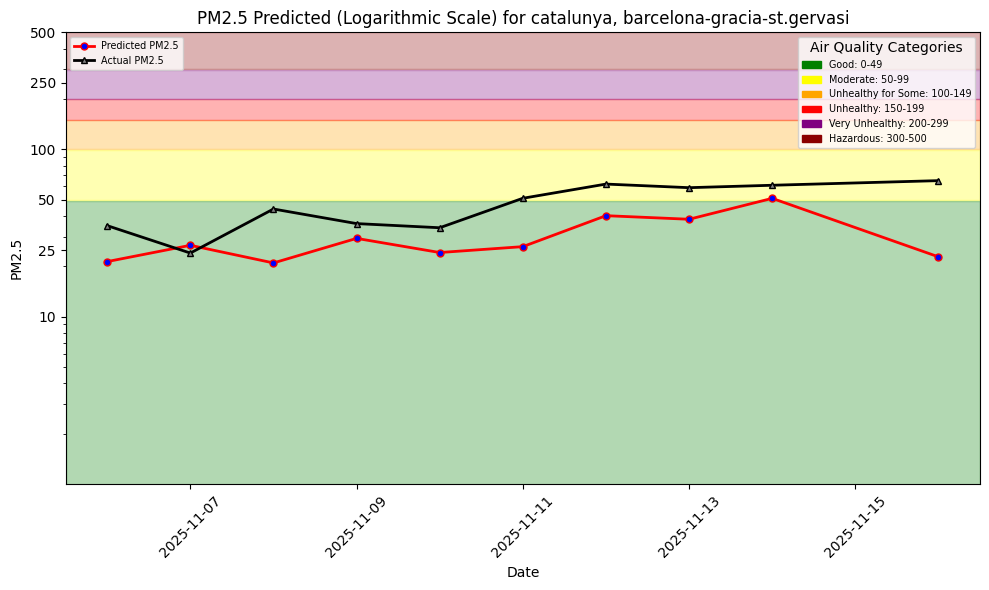

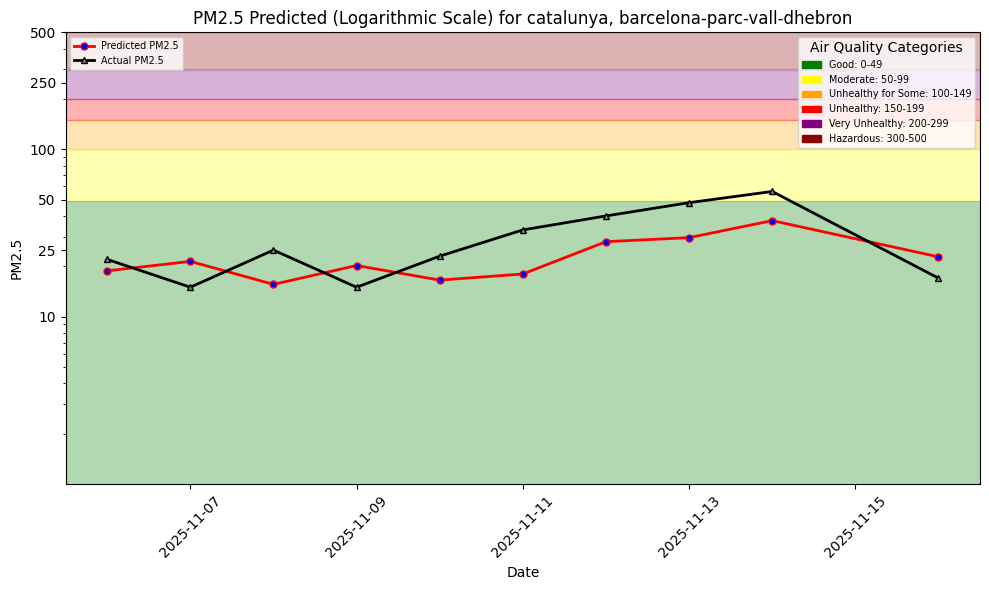

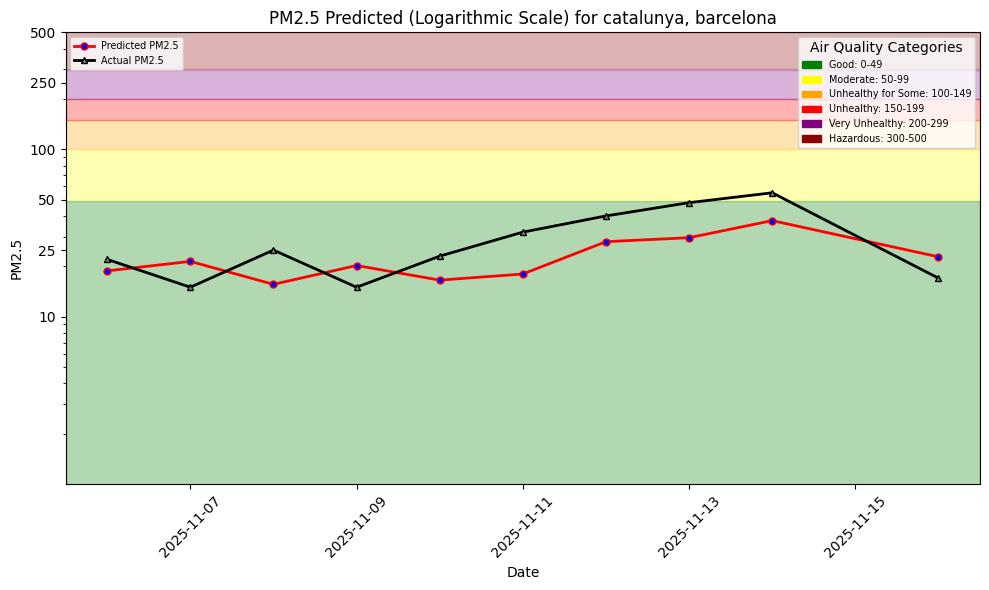

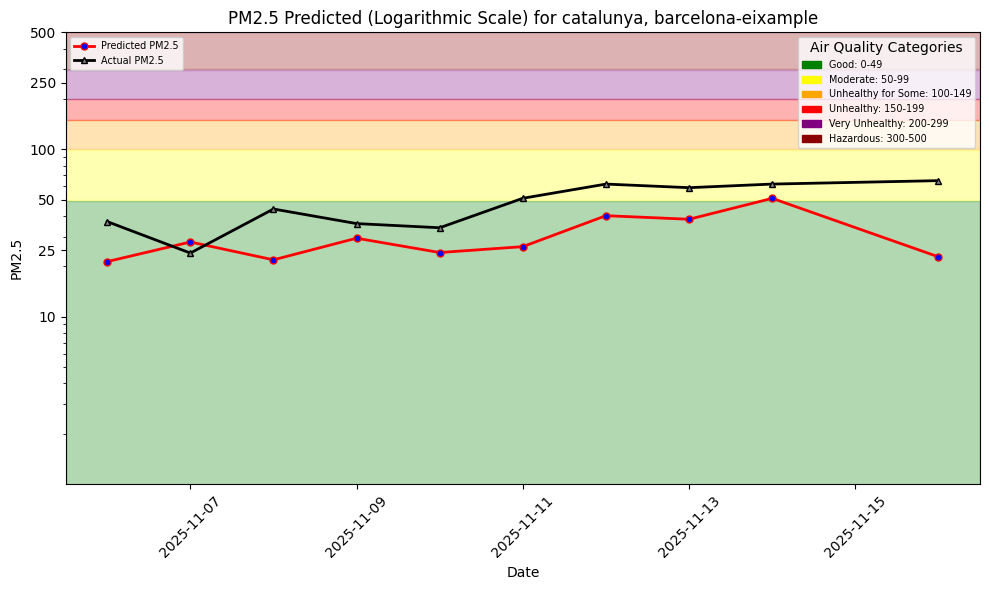

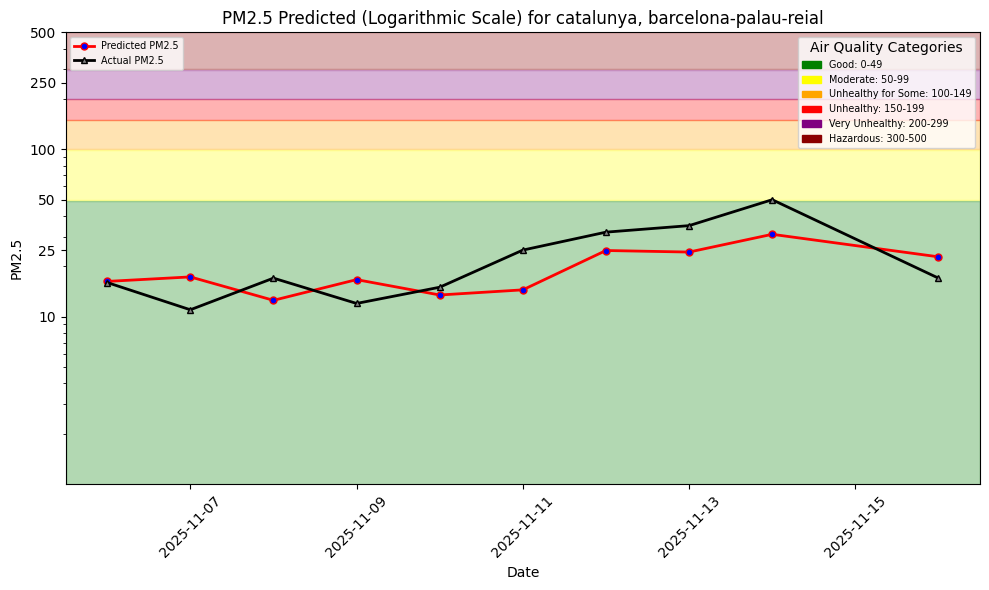

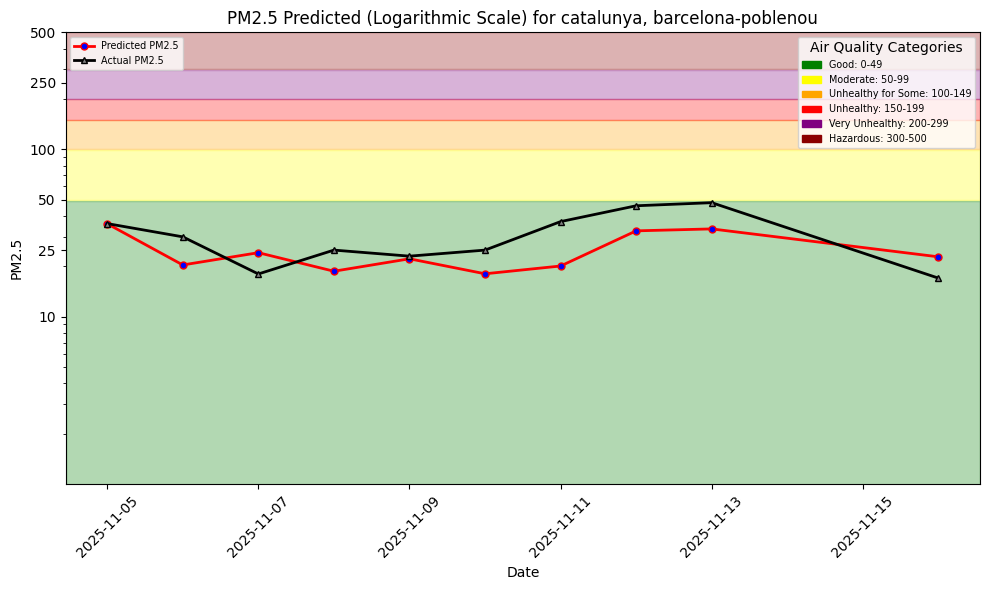

In [55]:
for s, hindcast in hindcasts.items():
    path_name = re.sub(r"[^A-Za-z0-9]+","_", s) 
    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{path_name}.png"
    plt = util.plot_air_quality_forecast(city, s, hindcast, hindcast_file_path, hindcast=True)
    plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [56]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
for s in streets:
    dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}_{path_name}", overwrite=True)
    dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}_{path_name}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality_v2")

Uploading /home/zohra/mlfs-book/docs/air-quality/assets/img/pm25_forecast_barcelona_poblenou.png: 0.000%|     …

Uploading /home/zohra/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_barcelona_poblenou.png: 0.000%|…

Uploading /home/zohra/mlfs-book/docs/air-quality/assets/img/pm25_forecast_barcelona_poblenou.png: 0.000%|     …

Uploading /home/zohra/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_barcelona_poblenou.png: 0.000%|…

Uploading /home/zohra/mlfs-book/docs/air-quality/assets/img/pm25_forecast_barcelona_poblenou.png: 0.000%|     …

Uploading /home/zohra/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_barcelona_poblenou.png: 0.000%|…

Uploading /home/zohra/mlfs-book/docs/air-quality/assets/img/pm25_forecast_barcelona_poblenou.png: 0.000%|     …

Uploading /home/zohra/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_barcelona_poblenou.png: 0.000%|…

Uploading /home/zohra/mlfs-book/docs/air-quality/assets/img/pm25_forecast_barcelona_poblenou.png: 0.000%|     …

%6|1763312964.181|FAIL|rdkafka#consumer-14| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50073ms in state UP, 1 identical error(s) suppressed)
%6|1763312964.386|FAIL|rdkafka#consumer-14| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50278ms in state UP, 1 identical error(s) suppressed)


Uploading /home/zohra/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_barcelona_poblenou.png: 0.000%|…

%6|1763312966.844|FAIL|rdkafka#producer-13| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 94822ms in state UP, 1 identical error(s) suppressed)


Uploading /home/zohra/mlfs-book/docs/air-quality/assets/img/pm25_forecast_barcelona_poblenou.png: 0.000%|     …

Uploading /home/zohra/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_barcelona_poblenou.png: 0.000%|…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279126/settings/fb/path/Resources/airquality_v2


---